In [1]:
"""
CREATED FROM COMBINING RESEARCH FROM:

https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

and credits for how to create a VARMA model as well

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/


and

my brain for the feature selection and combining xgboost to decide which variables
to use for prediction >:) (delete this before final submission)
"""

'\nCREATED FROM COMBINING RESEARCH FROM:\n\nhttps://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/\nhttps://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/\n\nand credits for how to create a VARMA model as well\n\nhttps://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/\n\n\nand\n\nmy brain for the feature selection and combining xgboost to decide which variables\nto use for prediction >:) (delete this before final submission)\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from pmdarima import auto_arima
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#Imported to ignore warnings from ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def format_data(path):
    df = pd.read_excel(path, index_col='Year', parse_dates=True)
    df2 = df.drop(columns=['Country Name', 'Country Code'])
    df2 = df2.dropna(axis=1, how='all')
    
    #Have to shift GDP Growth to last column because that will be the target
    #Refactored from a stackoverflow post
    df3 = df2[[column for column in df2 if column not in ['GDP growth (annual %)']] + ['GDP growth (annual %)']]
    
    return df3

In [5]:
#Handle missing data using mean imputation. Cannot use linear imputation as not always
#2 adjacent points are known

def fillmissing(data):
        
    newdata = data.fillna(data.mean())
    
    return newdata

In [6]:
data = format_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Multivariate More.xlsx')

In [7]:
data.drop(data.tail(1).index,inplace=True) #remove last row

In [8]:
filled_data = fillmissing(data)

In [9]:
#Using Feature Importance to select best influences
def feature_selection(model, X_train, X_test, y_train):
    
    selector = SelectFromModel(model, max_features=10, threshold=-np.inf)
    selector.fit (X_train, y_train)
    
    select_X_train = selector.transform(X_train)
    select_X_test = selector.transform(X_test)
    
    #print (selector.get_feature_names_out())
    
    selection_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=1, learning_rate = 0.1)
    selection_model.fit(select_X_train, y_train)
    
    select_y_pred = selection_model.predict(select_X_test)
    
    selection_model.get_booster().feature_names = selector.get_feature_names_out().tolist()
    plot_importance(selection_model.get_booster())
    
    return selector ,select_X_train ,select_y_pred

In [10]:
X = filled_data.iloc[:,:-1]
y = filled_data.iloc[:,-1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [12]:
#Using the hyperparameter tuned model for XGB

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=1, learning_rate=0.2)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

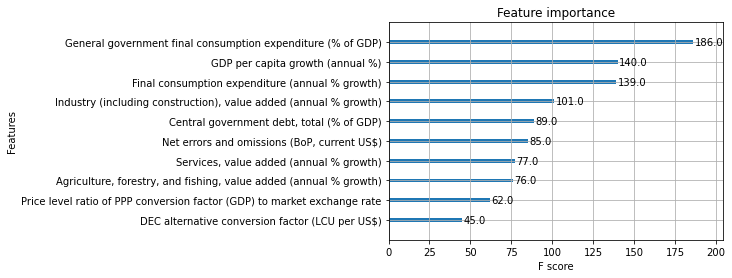

In [13]:
selector, select_X_train, select_y_pred = feature_selection(model, X_train, X_test, y_train)

In [14]:
best_indicators = filled_data[['GDP growth (annual %)', 
                               'General government final consumption expenditure (% of GDP)',
                              'Final consumption expenditure (% of GDP)',
                              'Foreign direct investment, net inflows (% of GDP)',
                              'Foreign direct investment, net outflows (% of GDP)',
                              'Exports of goods and services (% of GDP)', 
                               'Imports of goods and services (% of GDP)']]

In [15]:
#Using the plot above, select columns for multivariate forecast and join with gdp growth
featurenames = selector.get_feature_names_out().tolist()
selected_data = filled_data[featurenames]
gdp_data = pd.DataFrame(y)
joined_data = pd.concat([selected_data, gdp_data], axis=1)

In [16]:
"""
Method for this way of checking for stationarity comes from and refactored from the guide:

https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
"""
#Check stationarity
coint_johansen(best_indicators, -1,1).eig

#All eigenvalues are less than 1 therefore it is stationary
#We dont use adfuller because the VARMA model does not take into account the differencing order
#Eigenvalue condition fulfilled therfore, proceed

array([0.57067771, 0.36245415, 0.25390001, 0.19118498, 0.17541883,
       0.08048844, 0.02371741])

In [17]:
#Split into train test
test_size = len(best_indicators) - int(len(best_indicators) * 0.8)
train = best_indicators[:-test_size]
test = best_indicators[-test_size:]

In [18]:
"""
CREDITS FOR IDEA OF USING AUTO-ARIMA IN CONJUCTION WITH VARMA GOES TO:

https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/
"""

def stepwisefits(data, name=""):
    stepwise_fit = auto_arima(data, trace=True, suppress_warnings=True)
    
    print(f'{name} best')
    stepwise_fit.summary()

In [19]:
for name, column in train.iteritems():
    stepwisefits(column, name=column.name)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=266.509, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=264.510, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=260.618, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=260.861, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=315.927, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=262.585, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=262.572, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=264.550, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=273.762, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.197 seconds
GDP growth (annual %) best
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=163.955, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=193.627, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=161.001, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] interc

In [20]:
#(1,0,0), (0,1,0), (0,0,1), (1,0,1), (0,0,2)
#Eliminate (0,1,0) as no differencing in order for VARMA

In [21]:
#Create model
model = VARMAX(train, order=(1,0))
model_fit = model.fit(disp=False)
y_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [22]:
df1 = pd.DataFrame(y_pred)

In [23]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [24]:
#Get the RMSE for GDP 
df2 = df1['GDP growth (annual %)']

In [25]:
test2 = test['GDP growth (annual %)']

RMSE:  0.5540838192206987
MAPE:  8.85203071133509
MAE:  0.4749526023637937
Scatter Index:  10.260210903618516
MDA:  0.45454545454545453
Mean of actual:  5.400316079519256


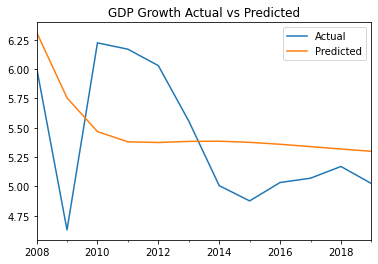

In [26]:
df_compare = pd.DataFrame({'Actual' : test2, 'Predicted' : df2})
df_compare.plot(title='GDP Growth Actual vs Predicted')
performance_metrics(test2, df2)

In [27]:
#The error xth leading minor of the array is not positive definite

"""
Answer from github

For now you cannot do much about this except looking for longer time series (e.g. quarterly data) or reducing the number of variables in the VAR. 
Essentially, the sample is much too short to get reliable estimates for time series analysis.

We won't be able to get more information out of the data, but a possible solution is to use some penalization or regularization, or impose more prior structure.
Specifically to the estimation of the covariance of the residuals: We could use SVD or eigenvalue decomposition instead of cholesky and handle singular sigma_u_mle. I'm not sure what the interpretation of a singular covariance matrix is in this case. We could also force it to be positive definite, but that's a purely numerical solution.

"""

#Tomorrow try less variables

"\nAnswer from github\n\nFor now you cannot do much about this except looking for longer time series (e.g. quarterly data) or reducing the number of variables in the VAR. \nEssentially, the sample is much too short to get reliable estimates for time series analysis.\n\nWe won't be able to get more information out of the data, but a possible solution is to use some penalization or regularization, or impose more prior structure.\nSpecifically to the estimation of the covariance of the residuals: We could use SVD or eigenvalue decomposition instead of cholesky and handle singular sigma_u_mle. I'm not sure what the interpretation of a singular covariance matrix is in this case. We could also force it to be positive definite, but that's a purely numerical solution.\n\n"

In [28]:
joined_data

,Price level ratio of PPP conversion factor (GDP) to market exchange rate,DEC alternative conversion factor (LCU per US$),GDP per capita growth (annual %),"Services, value added (annual % growth)","Industry (including construction), value added (annual % growth)","Agriculture, forestry, and fishing, value added (annual % growth)",Final consumption expenditure (annual % growth),General government final consumption expenditure (% of GDP),"Central government debt, total (% of GDP)","Net errors and omissions (BoP, current US$)",GDP growth (annual %)
Year,,,,,,,,,,,
1960-01-01,0.253254,4971.968728,3.263672,6.338879,6.114760,3.201808,5.332717,11.558175,35.691804,-8.058210e+08,5.253679
1961-01-01,0.253254,4971.968728,2.985794,9.935380,11.785714,1.663498,5.716696,11.784727,35.691804,-8.058210e+08,5.740646
1962-01-01,0.253254,4971.968728,-0.821881,0.587803,-0.319489,3.272557,3.606676,6.239233,35.691804,-8.058210e+08,1.841978
1963-01-01,0.253254,4971.968728,-4.806156,1.387874,-4.967949,-3.712087,-3.505252,7.114809,35.691804,-8.058210e+08,-2.237030
1964-01-01,0.253254,4971.968728,0.791335,2.305476,0.674536,9.826046,2.515447,7.124133,35.691804,-8.058210e+08,3.529698
1965-01-01,0.253254,4971.968728,-1.610432,1.338028,1.675042,-3.553082,-1.137093,5.608604,35.691804,-8.058210e+08,1.081589
1966-01-01,0.253254,4971.968728,0.039250,0.069493,1.812191,4.793609,2.035114,8.800253,35.691804,-8.058210e+08,2.791347
1967-01-01,0.253254,149.582993,-1.339415,5.694444,3.074434,-1.694197,6.481141,7.372022,35.691804,-8.058210e+08,1.380403
1968-01-01,0.253254,296.291992,7.943619,9.461235,17.896389,9.952607,9.560147,7.459341,35.691804,-8.058210e+08,10.915179
